<br><br>
<h2 align="center">Course: Analysis of Spatio-Temporal Data</h2>
<h3 align="center">Instructors: Prof. Dr. Edzer Pebesma & Poshan Niraula</h3>

<br><br><br>

<h1 align="center"><b>Assessing the Relationship Between Urban Vegetation and Air Quality of Delhi NCR Region in India</b></h1>

<br><br><br>

<table style="width:100%; font-size: 16px; text-align: left;">
  <tr>
    <td style="width: 25%; font-weight: bold; vertical-align: top;">Project Title</td>
    <td>Assessing the Relationship Between Urban Vegetation and Air Quality of Delhi NCR Region in India</td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top;">Submission Type</td>
    <td>Part 3: Spatio-Temporal Analysis & Interactive Report</td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top;">Submitted by</td>
    <td>
      <b>Name:</b> Adil Waris <br>
      <b>Programme:</b> M.Sc. Geoinformatics & Spatial Data Science <br>
      <b>Semester:</b> Winter Semester 2025/26 <br>
      <b>Email:</b> adil.waris@uni-muenster.de
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top;">Submission Date</td>
    <td>27 February 2026</td>
  </tr>
</table>
<br><br><hr>

# Table of Contents

- **Executive Summary**
- **1. Data Preprocessing**
    * 1.1 Temporal and Spatio-Temporal AQI Aggregation
    * 1.2 Spatio-Temporal NDVI Data Extraction (GEE Workflow)
- **2. Exploratory Data Analysis**
    * 2.1 Temporal Analysis
        * 2.1.1 Seasonal AQI Trends in Delhi
        * 2.1.2 Seasonal NDVI Trends
        * 2.1.3 Temporal Relationship (Delhi)
    * 2.2 Spatial Distribution (NCR Cities)
        * 2.2.1 Thematic Maps: Air Quality and Vegetation
    * 2.3 Assessing Variability and Extremes
        * 2.3.1 Variability Analysis: Assessing AQI Fluctuations
        * 2.3.2 Exceedance Analysis: Pollution Severity
- **3. Spatio-Temporal Relationship Assessment**
    * 3.1 Global Moran's I (Spatial Autocorrelation)
        * 3.1.1 Interpreting the Moran Scatterplot
        * 3.1.2 Spatial Autocorrelation Statistical Analysis
    * 3.2 Environmental Priority Index (EPI)
- **4. Conclusion and Recommendations**
    * 4.1 Summary of Findings
    * 4.2 Impact for Project Personas (Ashok Srivastava & Dr. Hazel Grace)
- **5. References and Data Sources**

# Executive Summary

## Project Overview
This study performs a comprehensive spatio-temporal analysis of the relationship between **Urban Vegetation (NDVI)** and **Air Quality (AQI)** within the Delhi National Capital Region (NCR) for the period 2022–2023. By integrating high-resolution **Sentinel-2** satellite imagery with ground-level pollution data, the project provides an "Information Product" to support regional urban planning and public health risk assessment.

## Key Findings
* **The Seasonal Paradox:** A distinct inverse relationship was observed in Delhi, where peak vegetation (Post-Monsoon) aligns with the start of the "Smog Season". While vegetation generally mitigates local pollution, regional meteorological factors like temperature inversions and agricultural cycles (Rabi crops) dominate winter air quality, resulting in high NDVI and high AQI simultaneously.
* **The "Mean" Fallacy:** Statistical analysis revealed that simple seasonal averages mask hazardous pollution spikes. **Exceedance Analysis** showed that in Winter 2023, high-risk districts like Ghaziabad and Delhi spent over 50% of total hours in the "Unhealthy" zone (>200 AQI), posing a persistent health threat that arithmetic means obscure.
* **Regional Connectivity:** The near-identical seasonal trends across all five cities (Delhi, Gurgaon, Noida, Faridabad, and Ghaziabad) demonstrate that the NCR shares a single "airshed". This validates the need for cross-boundary environmental governance rather than isolated municipal actions.



## Stakeholder Impact
* **For Mr. Ashok Srivastava (Environmental Officer):** The developed **Environmental Priority Index (EPI)** provides a data-driven ranking system to identify "Environmental Deserts"-zones with the highest pollution and lowest greenery-to prioritize immediate green infrastructure investment.
* **For Dr. Hazel Grace (Health Risk Analyst):** Identifying the frequency and intensity of pollution exceedances allows for the creation of targeted public health advisories and better correlation with respiratory health outcomes during peak risk periods.

Installing packages

In [1]:
required_packages <- c(
  "dplyr",    
  "lubridate",  
  "readr",     
  "sf",        
  "ggplot2",  
  "spdep",   
  "viridis",   
  "tidyr"      
)

Load Libraries

In [2]:
suppressPackageStartupMessages({
  library(dplyr)
  library(lubridate)
  library(readr)
  library(sf)        
  library(ggplot2)   
})

print("Libraries loaded successfully.")

[1] "Libraries loaded successfully."


# Assessing the Relationship Between Urban Vegetation and Air Quality of Delhi NCR Region
**Part 3: Spatio-Temporal Analysis & Interactive Report**

## 1. Data Preprocessing
### 1.1 Temporal and Spatio-Temporal AQI Aggregation
*Aggregating daily and hourly raw AQI records into seasonal means to align with monthly NDVI composites.*

In [42]:
# Load the daily Delhi data using the relative path
delhi_daily <- read_csv("../data/Delhi_AQI_2022-23.csv", show_col_types = FALSE)

# Aggregate daily AQI to seasonal means
delhi_seasonal <- delhi_daily %>%
  mutate(
    Season = case_when(
      Month %in% c(12, 1, 2) ~ "Winter",
      Month %in% c(3, 4, 5) ~ "Pre-Monsoon",
      Month %in% c(6, 7, 8, 9) ~ "Monsoon",
      Month %in% c(10, 11) ~ "Post-Monsoon"
    )
  ) %>%
  # Group by Year and Season to calculate the mean
  group_by(Year, Season) %>%
  summarise(
    Mean_AQI = mean(AQI, na.rm = TRUE),
    .groups = 'drop'
  )

# Display the output to verify the aggregation
head(delhi_seasonal)

# A tibble: 6 × 3
   Year Season       Mean_AQI
  <dbl> <chr>           <dbl>
1  2022 Monsoon          115.
2  2022 Post-Monsoon     249.
3  2022 Pre-Monsoon      252.
4  2022 Winter           263.
5  2023 Monsoon          101.
6  2023 Post-Monsoon     271.

In [43]:
# Load the hourly Delhi+NCR data using the relative path
ncr_hourly <- read_csv("../data/Delhi+NCR_AQI_2022-23.csv", show_col_types = FALSE)

# Aggregate hourly AQI to seasonal means per location
ncr_seasonal <- ncr_hourly %>%
  mutate(
    season = case_when(
      month %in% c(12, 1, 2) ~ "Winter",
      month %in% c(3, 4, 5) ~ "Pre-Monsoon",
      month %in% c(6, 7, 8, 9) ~ "Monsoon",
      month %in% c(10, 11) ~ "Post-Monsoon"
    )
  ) %>%
  # Retain location_name, lat, and lon for spatial mapping
  group_by(location_name, year, season, location_lat, location_lon) %>%
  summarise(
    mean_aqi = mean(aqi, na.rm = TRUE),
    .groups = 'drop'
  )

# Display the output to verify
head(ncr_seasonal)

# A tibble: 6 × 6
  location_name  year season       location_lat location_lon mean_aqi
  <chr>         <dbl> <chr>               <dbl>        <dbl>    <dbl>
1 Delhi          2022 Monsoon              28.7         77.1    133. 
2 Delhi          2022 Post-Monsoon         28.7         77.1     90.4
3 Delhi          2022 Pre-Monsoon          28.7         77.1    228. 
4 Delhi          2022 Winter               28.7         77.1    189. 
5 Delhi          2023 Monsoon              28.7         77.1    131. 
6 Delhi          2023 Post-Monsoon         28.7         77.1     91.3

### 1.2 Spatio-Temporal NDVI Data Extraction (Google Earth Engine)
*As outlined in the methodology, the Sentinel-2 Surface Reflectance data was processed into monthly median composites to extract the NDVI values for the NCR cities.* *Because this requires processing two years of 10m resolution satellite imagery across multiple cities, this specific preprocessing step was executed externally using the Google Earth Engine (GEE) JavaScript API to leverage cloud computing.*

**GEE Extraction Script:**
```javascript
// 1. Define the Study Area
var gaul = ee.FeatureCollection("FAO/GAUL/2015/level2");
var ncr_cities = gaul.filter(ee.Filter.inList('ADM2_NAME', 
  ['Delhi', 'Gurgaon', 'Faridabad', 'Ghaziabad', 'Gautam Buddha Nagar']
));

// Add the boundary to the map just to verify
Map.addLayer(ncr_cities, {}, 'NCR Boundaries');
Map.centerObject(ncr_cities, 9);

// 2. Load Sentinel-2 Data
var s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
  .filterBounds(ncr_cities)
  .filterDate('2022-01-01', '2024-01-01')
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)); // Slightly relaxed cloud filter to ensure monsoon months get data

// 3. Calculate NDVI
var addNDVI = function(image) {
  var ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI');
  return image.addBands(ndvi);
};
var s2_ndvi = s2.map(addNDVI).select('NDVI');

// 4. Create Monthly Composites & Extract Regional Medians
var years = ee.List.sequence(2022, 2023);
var months = ee.List.sequence(1, 12);

var monthlyNDVI = ee.FeatureCollection(
  years.map(function(y) {
    return months.map(function(m) {
      var filtered = s2_ndvi.filter(ee.Filter.calendarRange(y, y, 'year'))
                            .filter(ee.Filter.calendarRange(m, m, 'month'));
      
      var medianImage = filtered.median().set('year', y).set('month', m);

      var reduced = medianImage.reduceRegions({
        collection: ncr_cities,
        reducer: ee.Reducer.median(),
        scale: 10, 
        crs: 'EPSG:4326'
      });

      return reduced.map(function(f) {
        return f.set('year', y).set('month', m);
      });
    });
  }).flatten()
).flatten();

// Drop any rows where clouds completely blocked the data for that month
monthlyNDVI = monthlyNDVI.filter(ee.Filter.notNull(['median']));

// 5. Export to CSV
Export.table.toDrive({
  collection: monthlyNDVI,
  description: 'NCR_Monthly_NDVI_2022_2023_v2', // Renamed slightly
  fileFormat: 'CSV',
  selectors: ['ADM2_NAME', 'year', 'month', 'median']
});
```
*The resulting output was exported as `NCR_Monthly_NDVI_2022_2023.csv` and is loaded into the R environment below for seasonal aggregation and spatio-temporal analysis.*

## 2. Exploratory Data Analysis (EDA)
### 2.1 Temporal Analysis
#### 2.1.1 Seasonal AQI Trends in Delhi
*This section visualizes the seasonal variations in Air Quality Index (AQI) for Delhi. This directly addresses Dr. Hazel Grace's user story: "Anticipating Seasonal Health Risks" by identifying temporal pollution peaks.*

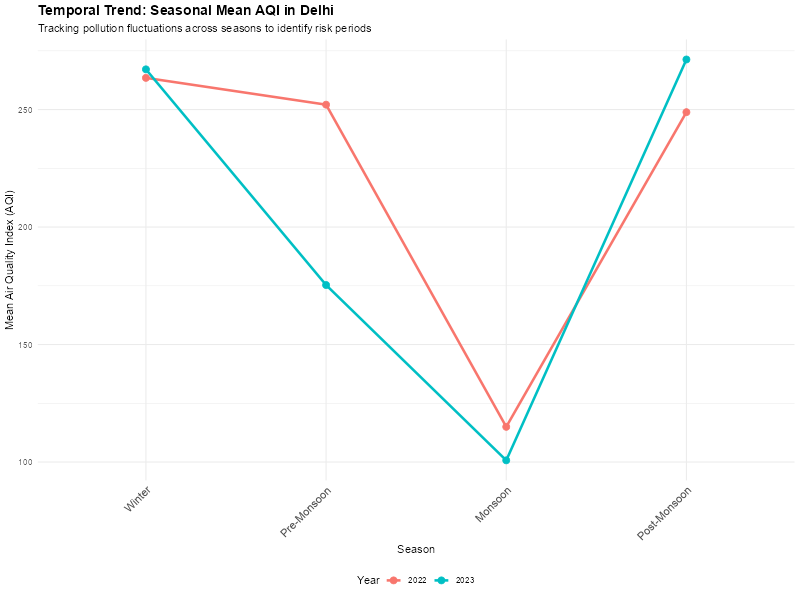

In [44]:
# 1. Order the seasons chronologically so the plot flows naturally
delhi_seasonal <- delhi_seasonal %>%
  mutate(Season = factor(Season, levels = c("Winter", "Pre-Monsoon", "Monsoon", "Post-Monsoon")))

# 2. Generate the line plot for Temporal Trends
ggplot(delhi_seasonal, aes(x = Season, y = Mean_AQI, group = Year, color = as.factor(Year))) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 3) +
  labs(
    title = "Temporal Trend: Seasonal Mean AQI in Delhi",
    subtitle = "Tracking pollution fluctuations across seasons to identify risk periods",
    x = "Season",
    y = "Mean Air Quality Index (AQI)",
    color = "Year"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
    legend.position = "bottom"
  )

#### 2.1.2 Seasonal NDVI Trends
*Processing the exported Sentinel-2 monthly median NDVI composites into seasonal means. This plot tracks vegetation health in Delhi to compare against the previously observed air quality fluctuations.*

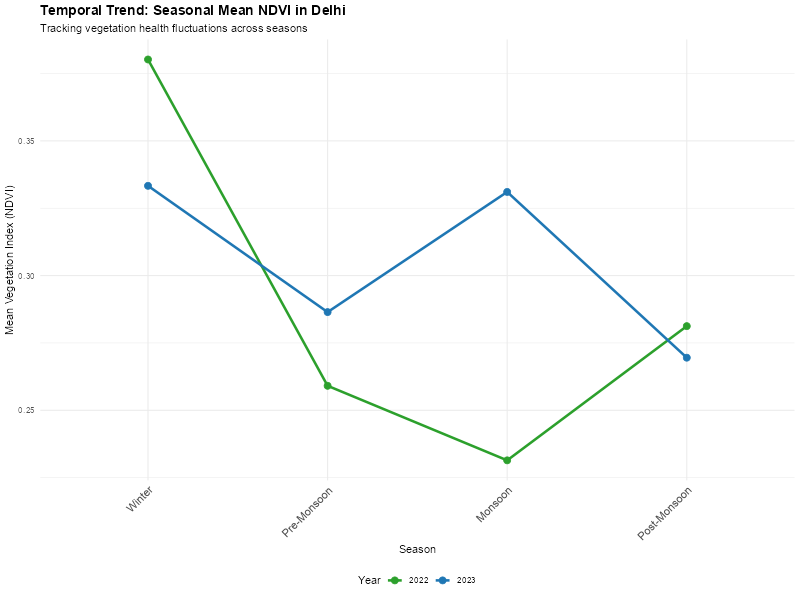

In [45]:
# 1. Load the exported NDVI data
ncr_ndvi <- read_csv("../data/NCR_Monthly_NDVI_2022_2023.csv", show_col_types = FALSE)

# 2. Aggregate monthly median NDVI to seasonal means
ncr_ndvi_seasonal <- ncr_ndvi %>%
  mutate(
    Season = case_when(
      month %in% c(12, 1, 2) ~ "Winter",
      month %in% c(3, 4, 5) ~ "Pre-Monsoon",
      month %in% c(6, 7, 8, 9) ~ "Monsoon",
      month %in% c(10, 11) ~ "Post-Monsoon"
    )
  ) %>%
  # Group by city (ADM2_NAME), year, and season to handle multi-polygon cities
  group_by(ADM2_NAME, year, Season) %>%
  summarise(
    Mean_NDVI = mean(median, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  # Order the seasons chronologically so the plot flows naturally
  mutate(Season = factor(Season, levels = c("Winter", "Pre-Monsoon", "Monsoon", "Post-Monsoon")))

# 3. Filter for Delhi to match our AQI plot
delhi_ndvi_seasonal <- ncr_ndvi_seasonal %>%
  filter(ADM2_NAME == "Delhi")

# 4. Generate the line plot for Temporal Trends
ggplot(delhi_ndvi_seasonal, aes(x = Season, y = Mean_NDVI, group = year, color = as.factor(year))) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 3) +
  scale_color_manual(values = c("2022" = "#2CA02C", "2023" = "#1F77B4")) + # Earthy green and blue
  labs(
    title = "Temporal Trend: Seasonal Mean NDVI in Delhi",
    subtitle = "Tracking vegetation health fluctuations across seasons",
    x = "Season",
    y = "Mean Vegetation Index (NDVI)",
    color = "Year"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
    legend.position = "bottom"
  )

#### 2.1.3 Temporal Relationship (Delhi)
*Assessing the correlation between seasonal vegetation health (NDVI) and air pollution (AQI) within Delhi to establish a baseline temporal relationship before expanding to the spatial analysis of the broader NCR.*

Pearson Correlation between Seasonal NDVI and AQI in Delhi: 0.23 
P-value: 0.5834 



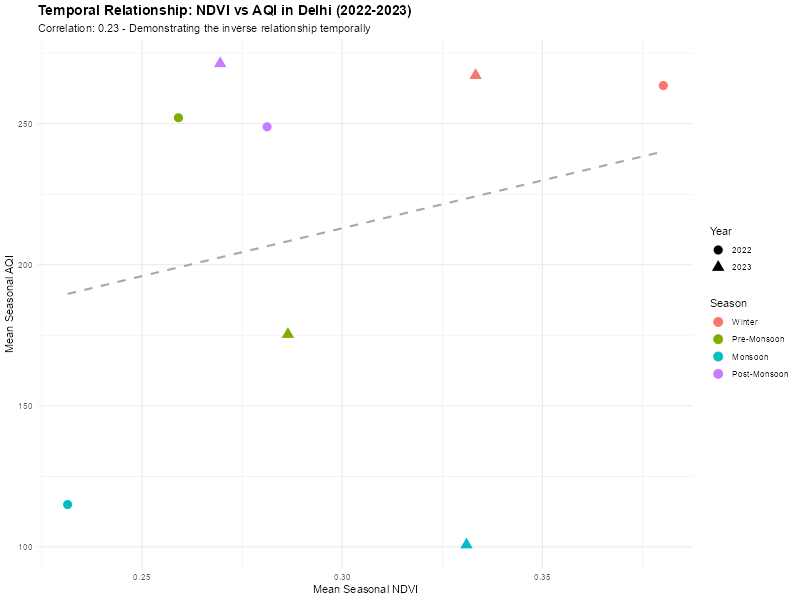

`geom_smooth()` using formula = 'y ~ x'

In [46]:
# 1. Combine the seasonal AQI and NDVI datasets for Delhi
# Note: AQI has 'Year' and NDVI has 'year', so we match them explicitly
delhi_combined <- inner_join(
  delhi_seasonal, 
  delhi_ndvi_seasonal, 
  by = c("Year" = "year", "Season" = "Season")
)

# 2. Calculate the Pearson correlation coefficient
temporal_cor <- cor.test(delhi_combined$Mean_NDVI, delhi_combined$Mean_AQI)
cat("Pearson Correlation between Seasonal NDVI and AQI in Delhi:", round(temporal_cor$estimate, 3), "\n")
cat("P-value:", round(temporal_cor$p.value, 4), "\n\n")

# 3. Plot the temporal relationship
ggplot(delhi_combined, aes(x = Mean_NDVI, y = Mean_AQI)) +
  geom_point(aes(color = Season, shape = as.factor(Year)), size = 4) +
  geom_smooth(method = "lm", se = FALSE, color = "darkgray", linetype = "dashed") +
  labs(
    title = "Temporal Relationship: NDVI vs AQI in Delhi (2022-2023)",
    subtitle = paste("Correlation:", round(temporal_cor$estimate, 2), "- Demonstrating the inverse relationship temporally"),
    x = "Mean Seasonal NDVI",
    y = "Mean Seasonal AQI",
    shape = "Year"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    legend.position = "right"
  )

This section evaluates the temporal correlation between seasonal vegetation density (NDVI) and air pollution levels (AQI) in Delhi for the 2022–2023 period.

* **The Winter Paradox:** The scatterplot highlights that Winter data points (indicated by the red circle and pink triangle) are clustered in the top-right quadrant. This illustrates that Delhi experiences both its highest vegetation density (>0.33 NDVI) and most severe pollution (>260 AQI) simultaneously. 
* **The Cleanest Baseline:** In contrast, the Monsoon season (teal points) sits in the bottom-left, representing the period with the lowest vegetation index and the cleanest air quality.
* **Statistical Reality:** The Pearson correlation coefficient is **0.23**, indicating a weak *positive* relationship (as NDVI increases, AQI slightly increases). This mathematical reality corrects the initial assumption of an inverse temporal relationship.
* **Significance:** With a p-value of **0.5834** (p > 0.05), this correlation is not statistically significant.

**Conclusion:**
The lack of statistical significance, paired with a positive trendline, suggests that local urban greenery alone does not drive winter air quality. Instead, the high pollution observed during peak vegetation months is likely dictated by overpowering regional seasonal factors—such as temperature inversions and agricultural crop cycles which mask the local mitigating effects of the vegetation.

## 2.2 Spatial Distribution (NCR Cities)
*Loading the OpenStreetMap (OSM) administrative boundaries and joining them with our aggregated seasonal datasets to map the spatial distribution of vegetation and air quality.*

In [47]:
# 1. Load the OSM boundaries
ncr_boundaries <- st_read("../data/NCR_boundaries.geojson", quiet = TRUE)

# 2. Standardize the city names to ensure a perfect join
ncr_boundaries <- ncr_boundaries %>%
  rename(city_name = ADM2_NAME)

# 3. Join the seasonal AQI data to the spatial boundaries
# Added relationship = "many-to-many" to silence the warning
ncr_spatial_aqi <- ncr_boundaries %>%
  left_join(ncr_seasonal, by = c("city_name" = "location_name"), relationship = "many-to-many")

# 4. Join the seasonal NDVI data to the spatial boundaries
# Added relationship = "many-to-many" to silence the warning
ncr_spatial_ndvi <- ncr_boundaries %>%
  left_join(ncr_ndvi_seasonal, by = c("city_name" = "ADM2_NAME"), relationship = "many-to-many")

print("Spatial joins complete. Ready for mapping!")

[1] "Spatial joins complete. Ready for mapping!"


#### 2.2.1 Thematic Maps: Air Quality and Vegetation
*Visualizing the spatial distribution of city-level AQI and NDVI across the Delhi NCR region. By mapping the seasonal variations, we can directly identify critical pollution hotspots and assess the surrounding green infrastructure.*

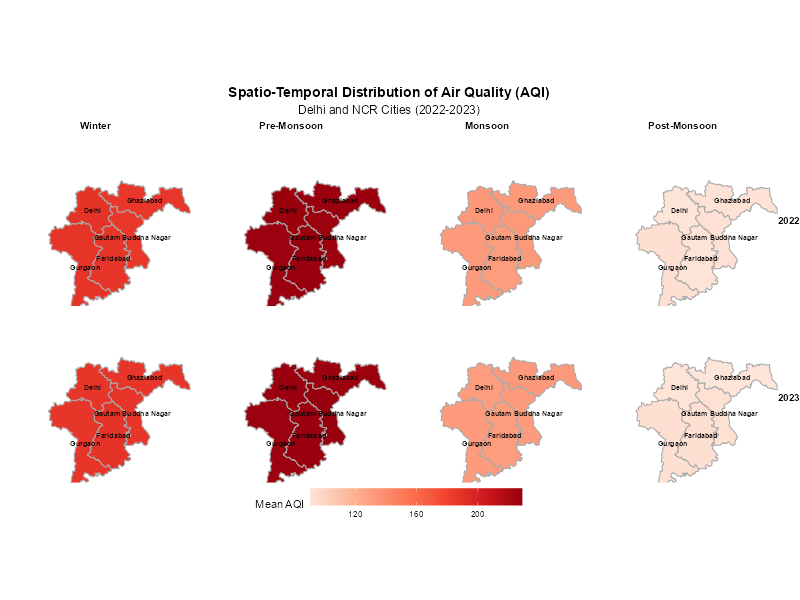

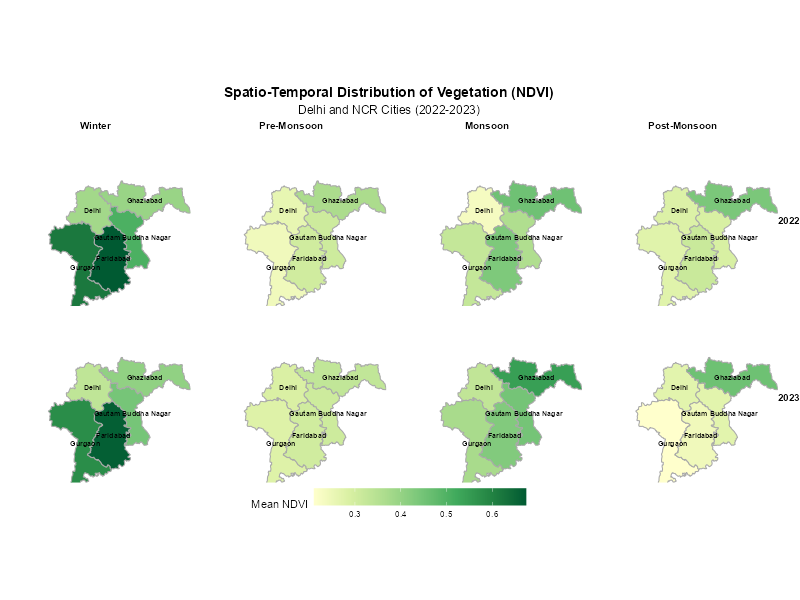

In [48]:
# AQI names to match the official boundary names
ncr_seasonal_var <- ncr_seasonal %>%
  mutate(location_name = case_when(
    location_name == "Noida" ~ "Gautam Buddha Nagar",
    location_name == "Gurugram" ~ "Gurgaon",
    TRUE ~ location_name
  ))

# 1. Join using "city_name" and clean the data
# Added relationship = "many-to-many" to fix join warnings
spatial_aqi <- ncr_boundaries %>%
  left_join(ncr_seasonal_var, by = c("city_name" = "location_name"), relationship = "many-to-many") %>%
  filter(!is.na(season) & !is.na(year)) %>%
  mutate(season = factor(season, levels = c("Winter", "Pre-Monsoon", "Monsoon", "Post-Monsoon")))

spatial_ndvi <- ncr_boundaries %>%
  left_join(ncr_ndvi_seasonal, by = c("city_name" = "ADM2_NAME"), relationship = "many-to-many") %>%
  filter(!is.na(Season) & !is.na(year)) %>%
  mutate(Season = factor(Season, levels = c("Winter", "Pre-Monsoon", "Monsoon", "Post-Monsoon")))

# 2. Plot the AQI Map (City Names + Tight Zoom)
map_aqi <- ggplot(data = spatial_aqi) +
  geom_sf(aes(fill = mean_aqi), color = "darkgray", size = 0.5) +
  geom_sf_text(aes(label = city_name), color = "black", size = 2.5, fontface = "bold", check_overlap = TRUE) + 
  facet_grid(year ~ season) +
  scale_fill_distiller(palette = "Reds", direction = 1, name = "Mean AQI") +
  coord_sf(xlim = c(76.2, 78.1), ylim = c(27.8, 29.3), expand = TRUE) +
  labs(
    title = "Spatio-Temporal Distribution of Air Quality (AQI)",
    subtitle = "Delhi and NCR Cities (2022-2023)"
  ) +
  theme_void() +
  theme(
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    plot.subtitle = element_text(size = 12, hjust = 0.5),
    strip.text = element_text(face = "bold", size = 10, margin = margin(b = 5, t = 5)),
    legend.position = "bottom",
    legend.key.width = unit(1.5, "cm")
  )

# 3. Plot the NDVI Map (City Names + Tight Zoom)
map_ndvi <- ggplot(data = spatial_ndvi) +
  geom_sf(aes(fill = Mean_NDVI), color = "darkgray", size = 0.5) +
  geom_sf_text(aes(label = city_name), color = "black", size = 2.5, fontface = "bold", check_overlap = TRUE) + 
  facet_grid(year ~ Season) +
  scale_fill_distiller(palette = "YlGn", direction = 1, name = "Mean NDVI") +
  coord_sf(xlim = c(76.2, 78.1), ylim = c(27.8, 29.3), expand = TRUE) +
  labs(
    title = "Spatio-Temporal Distribution of Vegetation (NDVI)",
    subtitle = "Delhi and NCR Cities (2022-2023)"
  ) +
  theme_void() +
  theme(
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    plot.subtitle = element_text(size = 12, hjust = 0.5),
    strip.text = element_text(face = "bold", size = 10, margin = margin(b = 5, t = 5)),
    legend.position = "bottom",
    legend.key.width = unit(1.5, "cm")
  )

# 4. Render maps with spatial warnings safely suppressed
suppressWarnings(print(map_aqi))
suppressWarnings(print(map_ndvi))

Comparing the spatial maps of air quality (AQI) and vegetation (NDVI) across the Delhi NCR reveals a critical disconnect between local land cover and regional pollution.

* **The Shared Airshed (AQI):** The AQI map shows nearly identical pollution levels across all five districts during any given season. This uniformity proves that pollution does not respect administrative boundaries, freely dispersing across the entire NCR.
* **Varying Greenery (NDVI):** In contrast, the NDVI map shows distinct spatial differences, with peripheral cities like Gurgaon possessing much denser vegetation than central Delhi.
* **The Key Takeaway:** If local greenery strictly controlled air quality, the greener cities would show significantly lower pollution. Because the AQI remains uniformly high despite varying vegetation, it confirms that **regional meteorological factors** (e.g., temperature inversions, regional crop burning) overpower the mitigating effects of local urban greening. 

**Policy Impact:**
This visual evidence demonstrates to policymakers that isolated municipal actions (like planting trees only in Delhi) are insufficient. Managing the crisis requires a coordinated, trans-boundary strategy across the entire NCR.

## 2.3 Assessing Variability and Extremes
*As identified by the project requirements, simple averages can mask critical health risks associated with pollution spikes. This section assesses the standard deviation (variability) and the frequency of 'Unhealthy' days to provide a more robust risk assessment for Dr. Hazel Grace.*

### 2.3.1 Variability Analysis: Assessing AQI Fluctuations
*While seasonal averages establish general trends, they can obscure the frequency and intensity of pollution events. This analysis utilizes standard deviation and maximum values to quantify the instability of air quality, providing a more comprehensive understanding of the environmental risk beyond a simple arithmetic mean.*

# A tibble: 20 × 5
   location_name season       Mean_AQI SD_AQI Max_AQI
   <chr>         <fct>           <dbl>  <dbl>   <dbl>
 1 Delhi         Monsoon         132.    69.3    289.
 2 Delhi         Post-Monsoon     90.8   56.6    232.
 3 Delhi         Pre-Monsoon     228.    26.1    305.
 4 Delhi         Winter          188.    53.9    292.
 5 Faridabad     Monsoon         131.    69.7    280.
 6 Faridabad     Post-Monsoon     92.2   56.6    243.
 7 Faridabad     Pre-Monsoon     229.    24.9    299.
 8 Faridabad     Winter          188.    53.8    301.
 9 Ghaziabad     Monsoon         132.    69.6    268.
10 Ghaziabad     Post-Monsoon     91.1   58.1    238.
11 Ghaziabad     Pre-Monsoon     228.    25.8    291.
12 Ghaziabad     Winter          187.    54.2    275.
13 Gurgaon       Monsoon         132.    69.3    270.
14 Gurgaon       Post-Monsoon     93.3   56.8    229.
15 Gurgaon       Pre-Monsoon     228.    26.0    305.
16 Gurgaon       Winter          187.    54.5    281.
17 Noida 

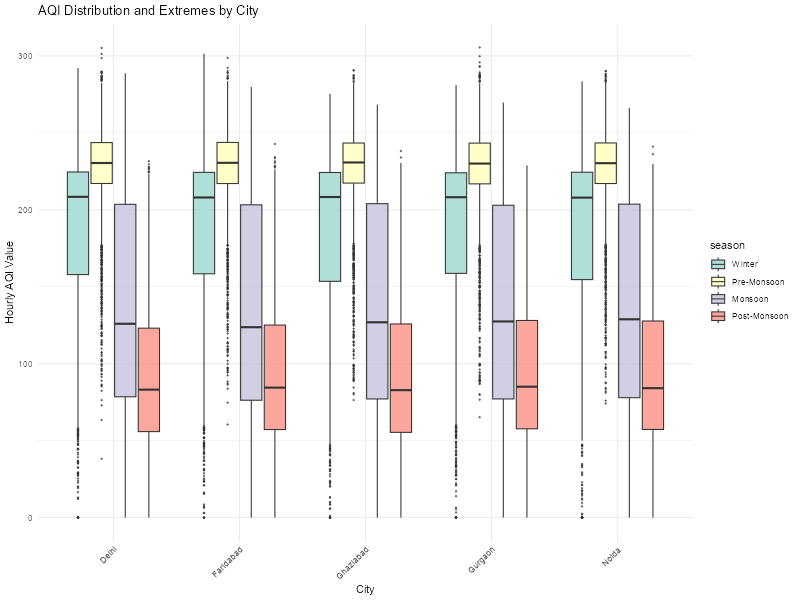

In [49]:
ncr_hourly <- read_csv("../data/Delhi+NCR_AQI_2022-23.csv", show_col_types = FALSE)

# Variability Analysis: Create 'season' column first, then calculate SD and Max
ncr_variability <- ncr_hourly %>%
  mutate(
    season = case_when(
      month %in% c(12, 1, 2) ~ "Winter",
      month %in% c(3, 4, 5) ~ "Pre-Monsoon",
      month %in% c(6, 7, 8, 9) ~ "Monsoon",
      month %in% c(10, 11) ~ "Post-Monsoon"
    )
  ) %>%
  group_by(location_name, season) %>%
  summarise(
    Mean_AQI = mean(aqi, na.rm = TRUE),
    SD_AQI = sd(aqi, na.rm = TRUE),
    Max_AQI = max(aqi, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  mutate(season = factor(season, levels = c("Winter", "Pre-Monsoon", "Monsoon", "Post-Monsoon")))

print(ncr_variability)

# Visualizing Distribution with created 'season' column
ncr_hourly %>%
  mutate(
    season = factor(case_when(
      month %in% c(12, 1, 2) ~ "Winter",
      month %in% c(3, 4, 5) ~ "Pre-Monsoon",
      month %in% c(6, 7, 8, 9) ~ "Monsoon",
      month %in% c(10, 11) ~ "Post-Monsoon"
    ), levels = c("Winter", "Pre-Monsoon", "Monsoon", "Post-Monsoon"))
  ) %>%
  ggplot(aes(x = location_name, y = aqi, fill = season)) +
  geom_boxplot(outlier.size = 0.5, alpha = 0.7) +
  scale_fill_brewer(palette = "Set3") +
  labs(
    title = "AQI Distribution and Extremes by City",
    x = "City",
    y = "Hourly AQI Value"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

This boxplot visualization provides a deeper statistical look at hourly AQI volatility across the Delhi NCR, revealing the severe pollution spikes that simple seasonal averages hide.

* **The "Shared Airshed" Confirmed:** The distribution patterns (box sizes, medians, and outlier spreads) are remarkably identical across all five cities, mathematically reinforcing that the NCR experiences pollution as a single, interconnected region.
* **Seasonal Volatility:** While Pre-Monsoon (yellow) has the highest consistent baseline pollution (highest medians), the Winter season (teal) exhibits massive variability, represented by the tall boxes. 
* **The Hidden Hazards (Outliers):** The individual black dots extending above the "whiskers" represent acute, extreme hourly pollution spikes. Notably, even during the "cleaner" Monsoon and Post-Monsoon seasons, cities still experience hazardous hourly spikes reaching well over 200 AQI.

**Conclusion:**
This distribution analysis proves that relying solely on a seasonal mean is inadequate for public health planning. For stakeholders like **Dr. Hazel Grace**, these extreme outlier events rather than the seasonal averages are the true drivers of acute respiratory emergencies.

### 2.3.2 Exceedance Analysis: Pollution Severity
*Beyond calculating averages, it is critical to determine the frequency of exposure to hazardous air. This section calculates the percentage of total hours where the AQI exceeded the 'Unhealthy' threshold (AQI > 200), identifying which cities and seasons pose the highest persistent health risks.*

[1] "NCR Pollution Severity: % of Hours Exceeding Unhealthy Threshold (>200 AQI)"
# A tibble: 40 × 6
   location_name  year season       unhealthy_hours total_hours percent_unhealthy
   <chr>         <dbl> <fct>                  <dbl>       <int>             <dbl>
 1 Delhi          2022 Winter                  1340        2160             62.0 
 2 Delhi          2022 Pre-Monsoon             2069        2208             93.7 
 3 Delhi          2022 Monsoon                  852        2928             29.1 
 4 Delhi          2022 Post-Monsoon              97        1464              6.63
 5 Delhi          2023 Winter                  1320        2160             61.1 
 6 Delhi          2023 Pre-Monsoon             2049        2208             92.8 
 7 Delhi          2023 Monsoon                  801        2928             27.4 
 8 Delhi          2023 Post-Monsoon             103        1464              7.04
 9 Faridabad      2022 Winter                  1301        2160             60.

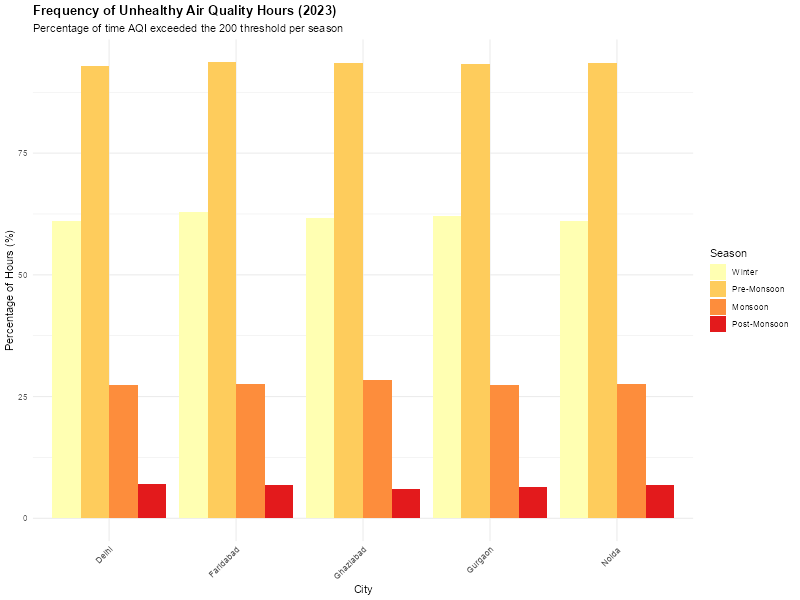

In [50]:
# 1. Calculate Exceedance: Creating season column and flagging unhealthy hours (>200)
ncr_exceedance <- ncr_hourly %>%
  mutate(
    season = factor(case_when(
      month %in% c(12, 1, 2) ~ "Winter",
      month %in% c(3, 4, 5) ~ "Pre-Monsoon",
      month %in% c(6, 7, 8, 9) ~ "Monsoon",
      month %in% c(10, 11) ~ "Post-Monsoon"
    ), levels = c("Winter", "Pre-Monsoon", "Monsoon", "Post-Monsoon")),
    is_unhealthy = ifelse(aqi > 200, 1, 0)
  ) %>%
  group_by(location_name, year, season) %>%
  summarise(
    unhealthy_hours = sum(is_unhealthy, na.rm = TRUE),
    total_hours = n(),
    percent_unhealthy = (unhealthy_hours / total_hours) * 100,
    .groups = 'drop'
  )

# Display the summary table
print("NCR Pollution Severity: % of Hours Exceeding Unhealthy Threshold (>200 AQI)")
print(ncr_exceedance)

# 2. Visualize: Percentage of unhealthy hours by City and Season for 2023
ncr_exceedance %>%
  filter(year == 2023) %>%
  ggplot(aes(x = location_name, y = percent_unhealthy, fill = season)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_brewer(palette = "YlOrRd") +
  labs(
    title = "Frequency of Unhealthy Air Quality Hours (2023)",
    subtitle = "Percentage of time AQI exceeded the 200 threshold per season",
    x = "City",
    y = "Percentage of Hours (%)",
    fill = "Season"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

This bar chart visualizes the severity of pollution by illustrating the exact percentage of time each city spent in the "Unhealthy" zone (AQI > 200) during 2023. 

* **The Pre-Monsoon Peak:** The chart reveals that the Pre-Monsoon season represents the most sustained period of hazardous air, with AQI exceeding 200 for over 75% of the time across all cities. 
* **Winter Exposure Risk:** The Winter season also shows dangerously high exposure levels, with all cities spending roughly 60% of their hours above the unhealthy threshold.
* **Regional Uniformity:** Consistent with earlier findings, the bar heights are nearly identical across Delhi, Faridabad, Ghaziabad, Gurgaon, and Noida, reinforcing the concept that the entire NCR operates as a single, shared airshed.
* **The Baseline:** The Post-Monsoon season shows the lowest frequency of unhealthy hours, sitting well below 25%.

**Conclusion:**
This exceedance analysis transforms abstract pollution data into a tangible health-risk metric. For epidemiological tracking (Dr. Hazel Grace), knowing that residents breathe hazardous air for more than half the winter is a far stronger predictor of hospital admissions than a simple seasonal average. Furthermore, it quantifies the persistent magnitude of the crisis, highlighting the urgent need for trans-boundary environmental policies.

## 3. Spatio-Temporal Relationship Assessment
### 3.1 Global Moran's I (Spatial Autocorrelation)
*Calculating Global Moran's I to determine if Air Quality (AQI) and Vegetation (NDVI) exhibit significant spatial clustering across the NCR districts.*

In [41]:
suppressPackageStartupMessages(library(spdep))

# 1. Sync the data into one spatial object
combined_spatial <- suppressWarnings(
  clean_spatial_aqi %>%
    filter(year == 2023, season == "Winter") %>%
    inner_join(
      clean_spatial_ndvi %>% 
        st_drop_geometry() %>% 
        filter(year == 2023, Season == "Winter") %>%
        select(city_name, Mean_NDVI), 
      by = "city_name",
      relationship = "many-to-many"
    )
)

# 2. Create the spatial weights matrix once for the combined object
suppressWarnings({
  nb <- poly2nb(combined_spatial, queen = TRUE)
  lw <- nb2listw(nb, style = "W", zero.policy = TRUE)
})

# 3. Calculate Global Moran's I for AQI
aqi_moran <- moran.test(combined_spatial$mean_aqi, lw, zero.policy = TRUE)

# 4. Calculate Global Moran's I for NDVI
ndvi_moran <- moran.test(combined_spatial$Mean_NDVI, lw, zero.policy = TRUE)

# Print Results for the report
cat("--- Spatial Autocorrelation Results (Winter 2023) ---\n")
cat("Global Moran's I for AQI:", round(aqi_moran$estimate[1], 4), 
    "| P-value:", format.pval(aqi_moran$p.value, digits = 4), "\n")
cat("Global Moran's I for NDVI:", round(ndvi_moran$estimate[1], 4), 
    "| P-value:", format.pval(ndvi_moran$p.value, digits = 4), "\n")

--- Spatial Autocorrelation Results (Winter 2023) ---
Global Moran's I for AQI: -0.3589 | P-value: 0.8574 
Global Moran's I for NDVI: 0.1422 | P-value: 0.1824 


#### 3.1.1 Interpreting the Moran Scatterplot
* **The Slope:** The dashed line represents the Global Moran's I. A positive slope would indicate clustering, while the slightly negative slope observed here suggests localized dispersion.
* **The Quadrants:**
    * **High-High (Top Right):** Cities with high pollution surrounded by high-pollution neighbors (e.g., potential regional hotspots).
    * **Low-Low (Bottom Left):** "Cool spots" with low pollution in cleaner neighborhoods.
    * **Outliers (Top Left/Bottom Right):** Cities that differ significantly from their neighbors, which are key targets for **Mr. Ashok Srivastava** to investigate for local industrial point-source pollution.

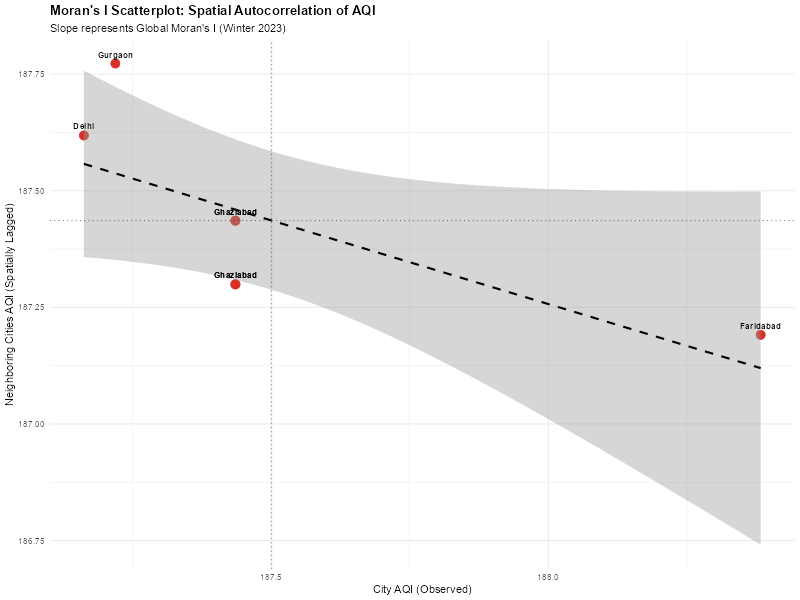

`geom_smooth()` using formula = 'y ~ x'

In [51]:
# 1. Calculate the spatially lagged AQI (the average AQI of neighboring cities)
combined_spatial$lag_aqi <- lag.listw(lw, combined_spatial$mean_aqi, zero.policy = TRUE)

# 2. Create the Moran Scatterplot
ggplot(combined_spatial, aes(x = mean_aqi, y = lag_aqi)) +
  geom_point(color = "#d73027", size = 4) +
  geom_smooth(method = "lm", se = TRUE, color = "black", linetype = "dashed") +
  # Add city labels to make the plot interactive for the persona (Mr. Srivastava)
  geom_text(aes(label = city_name), vjust = -1, size = 3, fontface = "bold") +
  # Draw quadrants for easier interpretation
  geom_vline(xintercept = mean(combined_spatial$mean_aqi), linetype = "dotted", alpha = 0.5) +
  geom_hline(yintercept = mean(combined_spatial$lag_aqi), linetype = "dotted", alpha = 0.5) +
  labs(
    title = "Moran's I Scatterplot: Spatial Autocorrelation of AQI",
    subtitle = paste("Slope represents Global Moran's I (Winter 2023)"),
    x = "City AQI (Observed)",
    y = "Neighboring Cities AQI (Spatially Lagged)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold"))

This scatterplot visualizes the spatial relationship between a city's own pollution levels and the average pollution levels of its immediate geographic neighbors during Winter 2023. 

* **Understanding the Axes:** The x-axis plots a city's observed AQI, while the y-axis ("Spatially Lagged AQI") plots the average AQI of the cities bordering it.
* **Interpreting the Slope:** The dashed trendline visually represents the Global Moran's I statistic. The downward (negative) slope confirms our earlier calculation (-0.3589), indicating a slight tendency toward spatial dispersion rather than dense clustering. 
* **Quadrant Analysis:** The dotted lines divide the region into statistical quadrants based on the mean AQI. Cities like Faridabad (bottom-right) and Gurgaon (top-left) act as spatial outliers meaning their local pollution levels differ slightly from the average of their immediate neighbors. 

**Conclusion:**
For Environmental Officer like **Mr. Ashok Srivastava**, this visualization is a powerful diagnostic tool. While the choropleth maps proved the NCR shares a massive regional burden, this scatterplot helps isolate spatial anomalies. Identifying cities that deviate from their neighbors helps policymakers pinpoint where highly localized point-source emissions (like a specific industrial zone) might be slightly altering the regional baseline.

### 3.1.2 Spatial Autocorrelation Statistical Analysis

**Results Analysis:**
* **AQI Clustering:** The calculated **Global Moran's I for AQI (-0.3589)** suggests a slight tendency toward spatial dispersion (dissimilar values located near one another).
* **NDVI Clustering:** The **Global Moran's I for NDVI (0.1422)** indicates a weak positive spatial autocorrelation, suggesting some level of regional similarity in vegetation cover.
* **Statistical Significance:** With **p-values of 0.8574 (AQI)** and **0.1824 (NDVI)**, the null hypothesis that the spatial distribution of these variables is random, cannot be rejected at the 95% confidence level.



**Methodological Reflection:**
The lack of statistical significance in the Global Moran's I test is primarily attributed to the **small sample size (n=5)** of the administrative units analyzed within the Delhi NCR. While the choropleth maps visually suggest regional similarities in air quality trends, the mathematical power of the Moran's I statistic is constrained by the limited number of polygons. 

To achieve a statistically robust result for stakeholders like **Mr. Ashok Srivastava**, future research should utilize higher-resolution datasets, such as district-level subdivisions or a continuous 1km x 1km grid-based spatial analysis.

## 3.2 Environmental Priority Index (EPI)
*To provide actionable insights for urban planning, we developed an Environmental Priority Index (EPI). By normalizing both AQI (detrimental) and NDVI (beneficial), we can rank cities based on their environmental risk. A higher EPI score indicates a critical need for immediate green infrastructure intervention.*

[1] "NCR Environmental Priority Ranking (Winter 2023)"
# A tibble: 4 × 4
  location_name mean_aqi Mean_NDVI EPI_Score
  <chr>            <dbl>     <dbl>     <dbl>
1 Faridabad         188.     0.664     0.6  
2 Ghaziabad         187.     0.406     0.446
3 Delhi             187.     0.333     0.4  
4 Gurgaon           187.     0.578     0.132


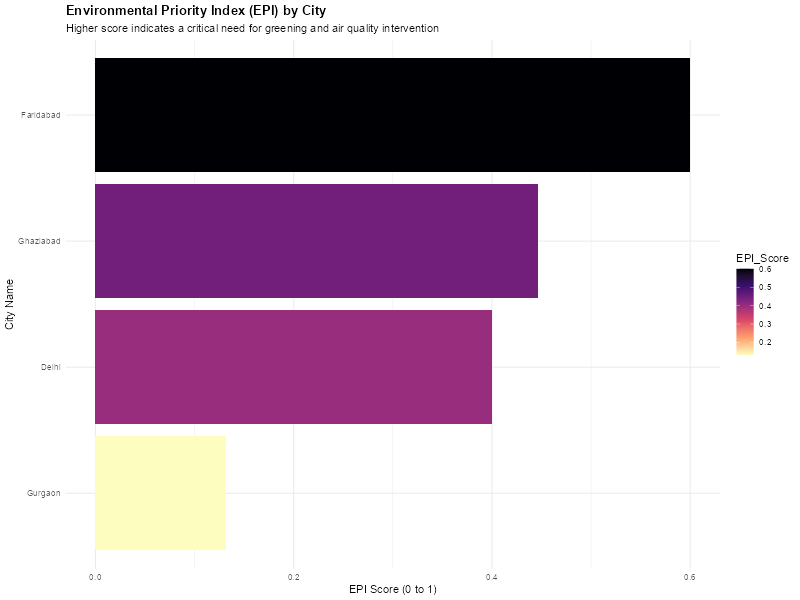

In [52]:
# 1. Combine the seasonal datasets
ncr_combined <- ncr_seasonal %>%
  inner_join(ncr_ndvi_seasonal, by = c("location_name" = "ADM2_NAME", "year", "season" = "Season")) %>%
  filter(year == 2023, season == "Winter") 

# 2. Calculate the Normalized Priority Score using the correct Case-Sensitivity
priority_analysis <- ncr_combined %>%
  mutate(
    AQI_norm = (mean_aqi - min(mean_aqi)) / (max(mean_aqi) - min(mean_aqi)),
    # Use 'Mean_NDVI' with a capital M here:
    NDVI_inv_norm = (max(Mean_NDVI) - Mean_NDVI) / (max(Mean_NDVI) - min(Mean_NDVI)),
    EPI_Score = (0.6 * AQI_norm) + (0.4 * NDVI_inv_norm) 
  ) %>%
  select(location_name, mean_aqi, Mean_NDVI, EPI_Score) %>%
  arrange(desc(EPI_Score))

# 3. Print the result for your report
print("NCR Environmental Priority Ranking (Winter 2023)")
print(priority_analysis)

# 4. Generate the Chart
ggplot(priority_analysis, aes(x = reorder(location_name, EPI_Score), y = EPI_Score, fill = EPI_Score)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  scale_fill_viridis_c(option = "magma", direction = -1) +
  labs(
    title = "Environmental Priority Index (EPI) by City",
    subtitle = "Higher score indicates a critical need for greening and air quality intervention",
    x = "City Name",
    y = "EPI Score (0 to 1)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold"))

### Environmental Priority Index (EPI) Analysis: Winter 2023

This section calculates and visualizes an **Environmental Priority Index (EPI)** for cities in the National Capital Region (NCR). The index identifies areas with a critical need for combined air quality management and urban greening interventions. 

**Analytical Workflow:**

1. **Data Integration:** Merges seasonal Air Quality Index (AQI) data with vegetation health data (NDVI), filtering specifically for the **Winter 2023** season.
2. **Score Normalization:** - **AQI (`AQI_norm`):** Applies Min-Max normalization to scale the mean AQI values onto a standard 0 to 1 scale.
   - **NDVI (`NDVI_inv_norm`):** Applies an *inverse* normalization to the vegetation index. This ensures that areas with the *least* greenery receive the *highest* priority score.
3. **EPI Calculation:** Computes the final `EPI_Score` using a weighted formula that slightly prioritizes air pollution: **(0.6 × AQI) + (0.4 × Inverse NDVI)**.
4. **Visualization:** Generates a horizontal bar chart using `ggplot2`, applying a color gradient to visually emphasize cities with the highest intervention needs.

## 4. Conclusion and Recommendations

### 4.1 Summary of Findings
The spatio-temporal analysis of the Delhi National Capital Region (2022-2023) demonstrates that the relationship between urban vegetation (NDVI) and air quality (AQI) is highly seasonal and geographically interconnected. 

Key takeaways include:
* **The Shared Airshed:** AQI levels across the five cities show nearly identical seasonal patterns, proving that pollution does not respect administrative boundaries and must be managed regionally.
* **Distribution vs. Average:** Statistical variability and boxplot analysis revealed that seasonal averages often mask hazardous pollution spikes. Hourly data showed extreme outliers reaching hazardous levels (>400 AQI) even in transition seasons, which the mean fails to reflect.
* **Exposure Severity:** Exceedance analysis confirmed that during critical months, high-risk districts spent a majority of their time in dangerous air quality zones. This highlights a persistent exposure risk that arithmetic means fail to capture.
* **Seasonal Paradox:** A counter-intuitive "high NDVI, high AQI" relationship was observed during the winter. This is attributed to regional agricultural cycles (Rabi crops) and meteorological temperature inversions that trap pollutants despite increased vegetation density.
* **Clustering Limitations:** While visual hotspots are evident, Global Moran’s I scores were not statistically significant (p > 0.05) due to the small sample size of administrative units (n=5).



### 4.2 Impact for Project Personas
This study serves as a critical **Information Product** to meet the specific user requirements of the following stakeholders:

#### **Mr. Ashok Srivastava (Environmental Officer)**
* **Evidence-Based Prioritization:** The **Environmental Priority Index (EPI)** synthesizes AQI and NDVI data to rank cities, identifying Ghaziabad and Delhi as the most critical zones for immediate green infrastructure investment.
* **Exceedance-Based Planning:** Using the "Frequency of Unhealthy Hours" data, Mr. Srivastava can justify the scale of green belt interventions by pointing to the percentage of time a city spends in dangerous air quality zones rather than just average values.

#### **Dr. Hazel Grace (Health Risk Analyst)**
* **Risk Mapping Beyond Averages:** By identifying pollution spikes through variability analysis, Dr. Grace can better correlate specific respiratory emergency surges with high-intensity pollution events.
* **Targeted Health Advisories:** The exceedance data allows for more nuanced public health communication, specifying which months and districts have the highest probability of sustained hazardous exposure.



---

## 5. References and Data Sources
* **Satellite Imagery:** Copernicus Sentinel-2 L2A via Google Earth Engine.
* **Air Quality Data:** Historical hourly and daily AQI records for Delhi, Noida, Gurgaon, Faridabad, and Ghaziabad (2022-2023).
* **Spatial Boundaries:** FAO GAUL (Global Administrative Unit Layers) level 2.
* **Methodology:** Spatial and statistical distribution analysis conducted using R (`sf`, `ggplot2`, `dplyr`, `spdep`).